##### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 3,54
MultiplierThresholdToBlock <strong>L 50</strong>, FractionThresholdToUnBlock 1, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result"
numberOfGenerations = 150;
percolation = 0.34;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]
filesInfected = [
    {"filename": "Netsim-Node-Metrics-IsInfected-{log_tag}", "title": "Доля инфицированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
summInfected = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatInfected():
    for file in filesInfected:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля инфицированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summInfected.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            dataI, line_lenI = load_csv_file(f"{log_dir_path}/{filesInfected[0]['filename'].format(log_tag = log_tag['tag'])}")
                                           
            aggregated, count = aggeregate_line_perc_node(data)
            aggregatedI, count = aggeregate_line_perc_node(dataI)
            aggregated = np.array(aggregated) - np.array(aggregatedI)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    showStatInfected();

def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%d.%m.%Y %H:%M:%S\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

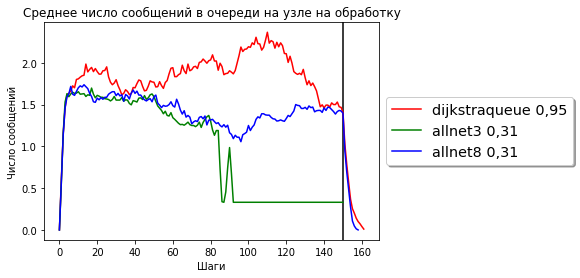

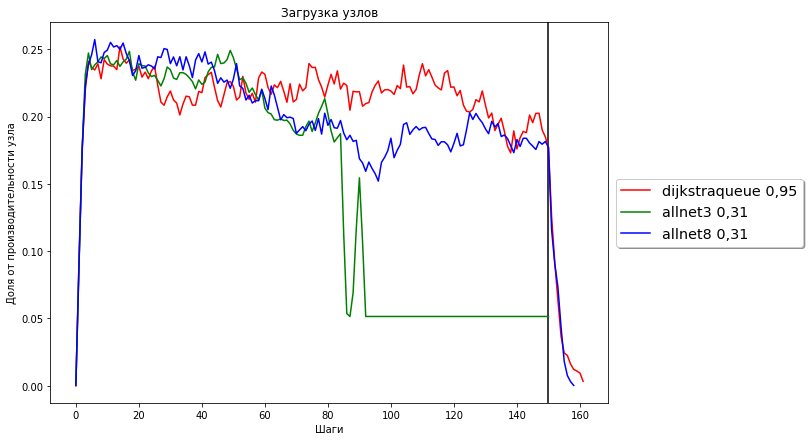

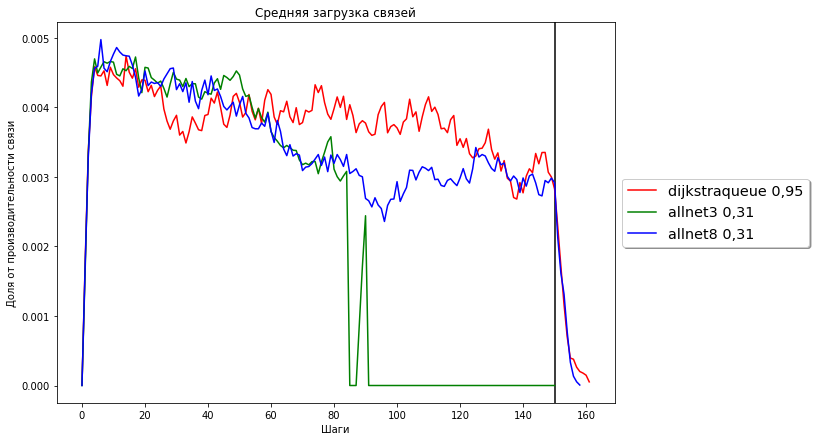

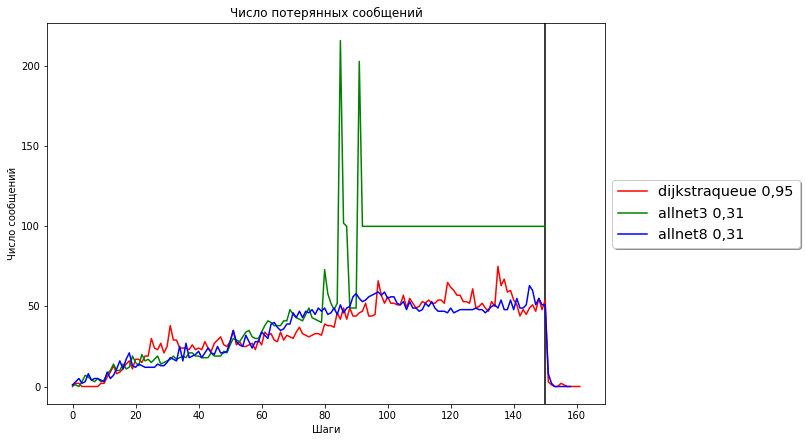

Доставлено 9588 Потеряно 36.0843% -dijkstraqueue 0,95
Доставлено 6233 Потеряно 58.4494% -allnet3 0,31
Доставлено 9583 Потеряно 36.1176% -allnet8 0,31


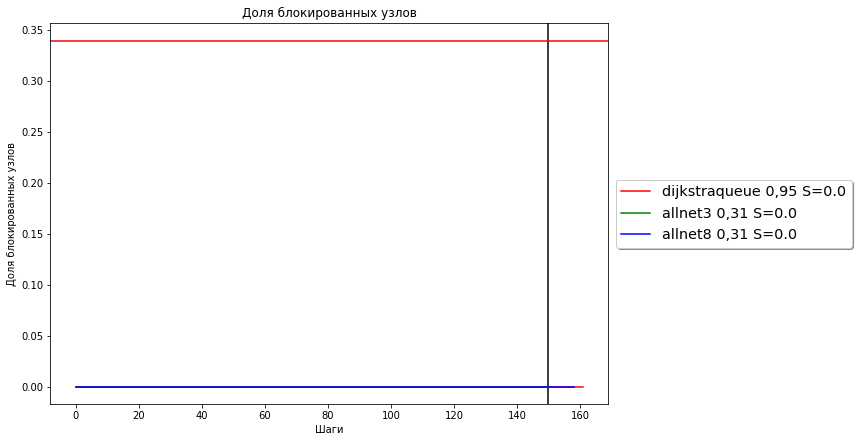

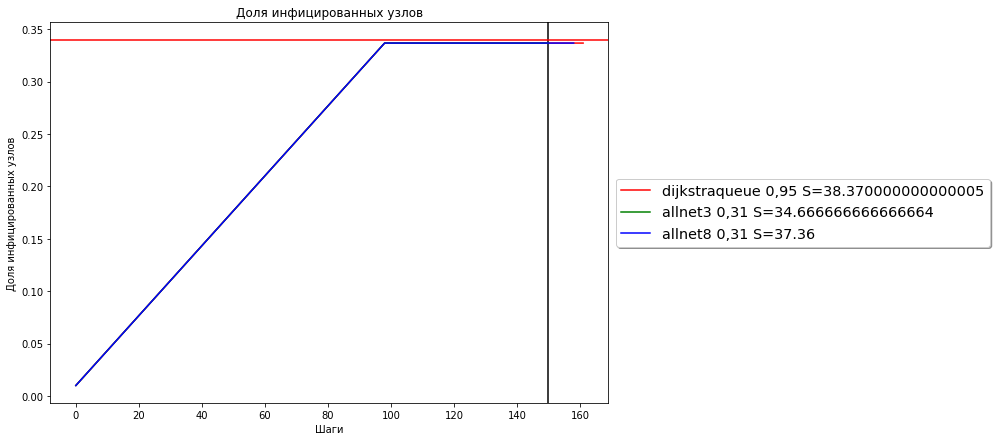

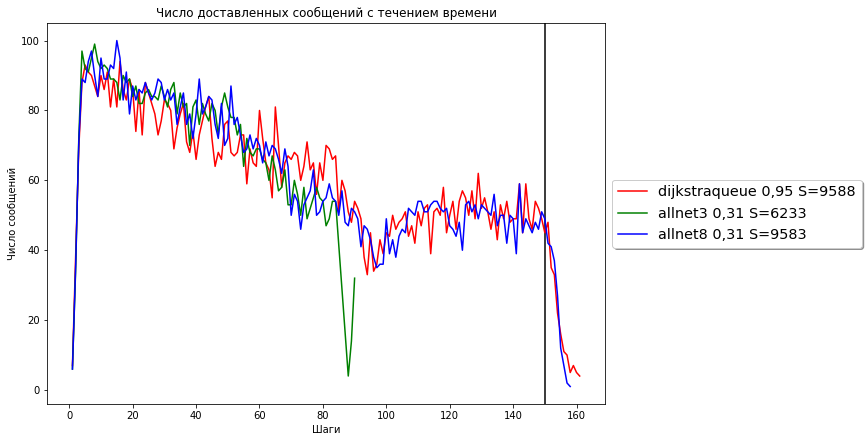

In [2]:
quantity = 100;
log_tags = [
{"tag":  "cb178f11-5ad4-46d3-a65a-aecb4bdb2b8f", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "fb092407-c268-4ae8-90c6-a22fc8edfb97", "label": "allnet3 0,31", "color": "green"},
{"tag":  "76dda6b5-3f00-4af9-8773-99128bf5212f", "label": "allnet8 0,31", "color": "blue"},
]
                             
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 500 </strong>

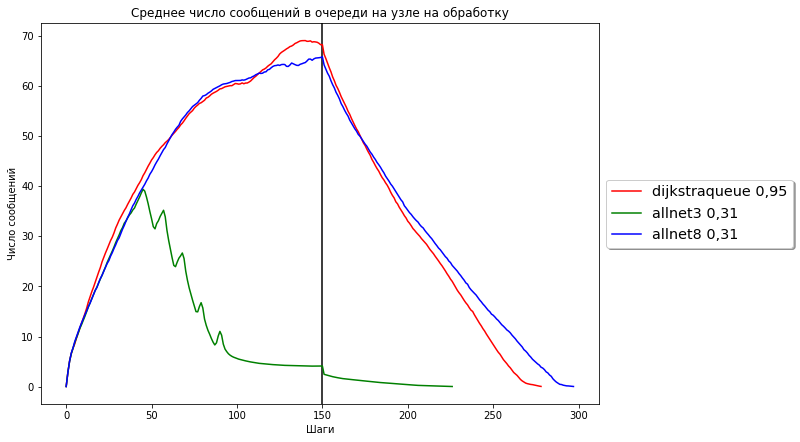

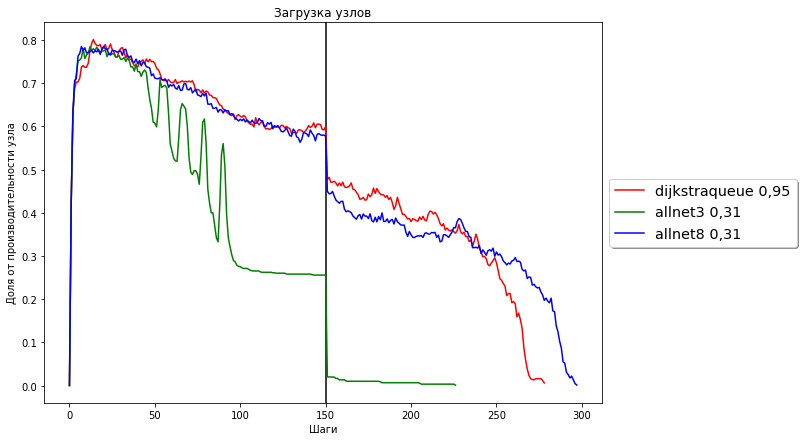

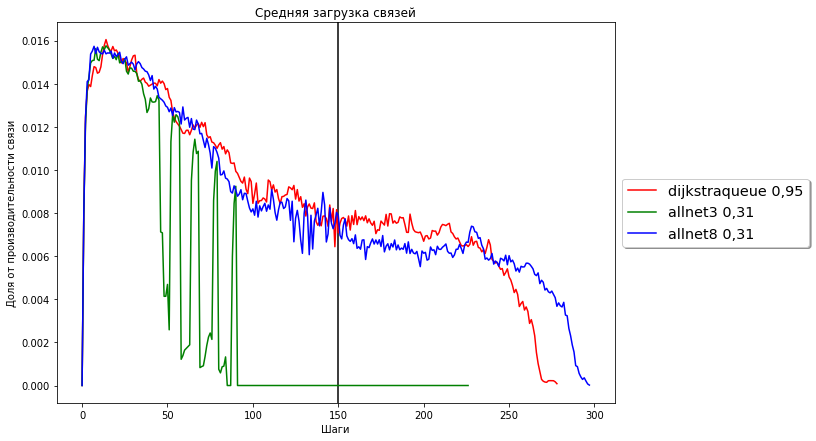

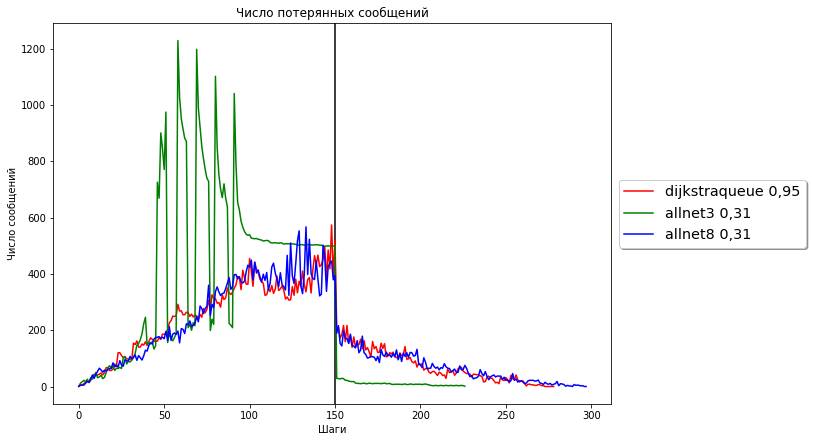

Доставлено 26972 Потеряно 64.0378% -dijkstraqueue 0,95
Доставлено 11261 Потеряно 84.9855% -allnet3 0,31
Доставлено 26341 Потеряно 64.8791% -allnet8 0,31


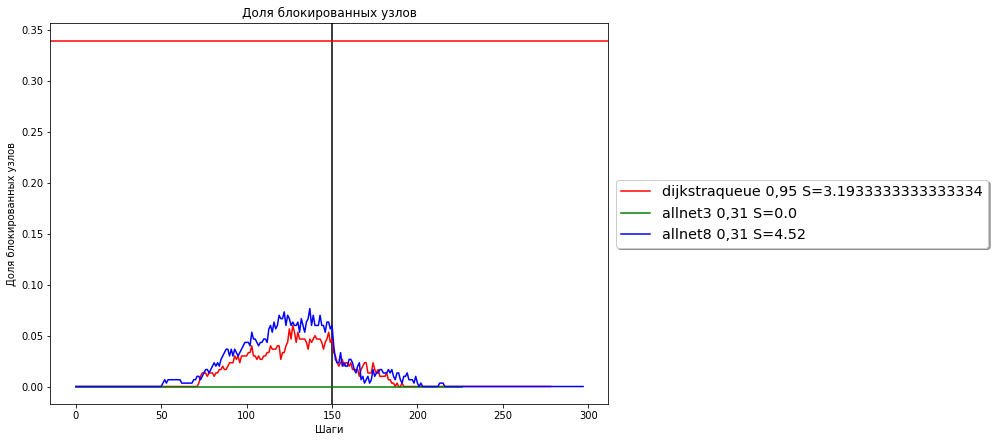

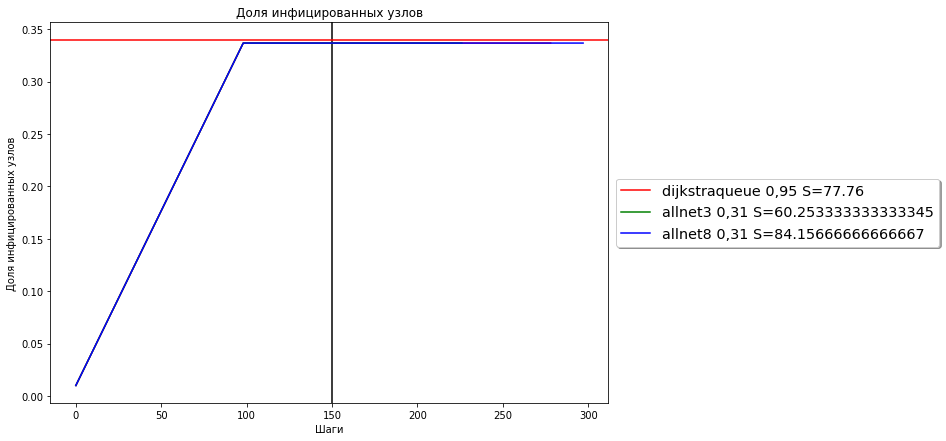

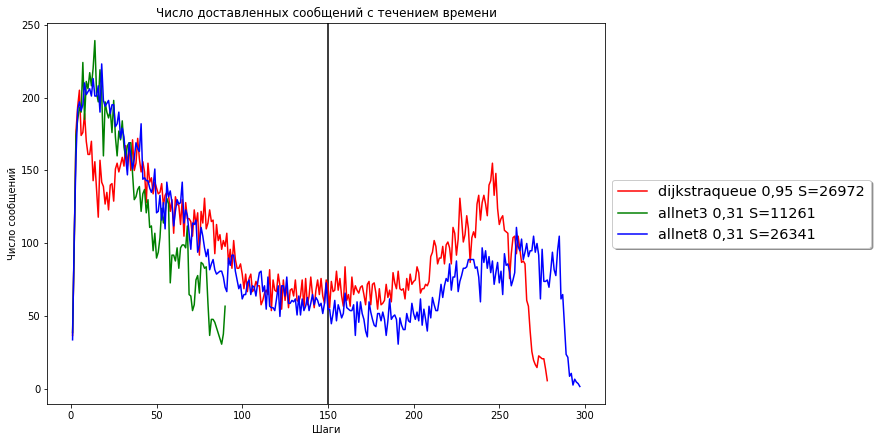

In [3]:
quantity = 500;
log_tags = [
{"tag":  "378a83b8-e4c7-46a4-afcc-8bfa273a98f4", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "44f4d391-27c2-4780-a9ee-458c378a1d91", "label": "allnet3 0,31", "color": "green"},
{"tag":  "dc9e6332-b368-4464-aabb-7531e3dc7de8", "label": "allnet8 0,31", "color": "blue"},
]
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

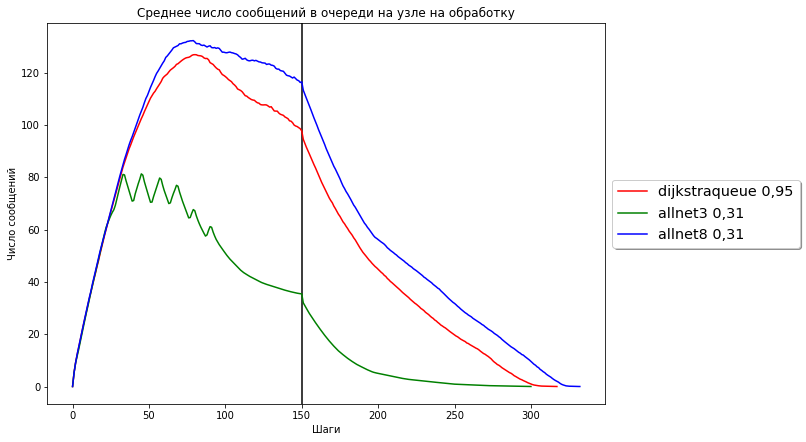

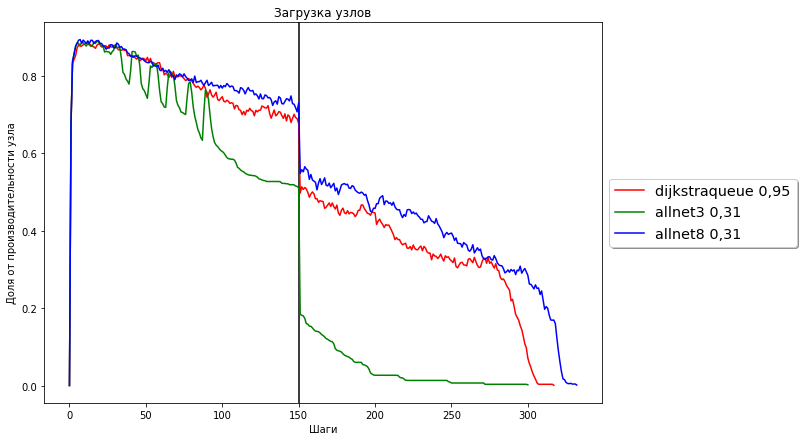

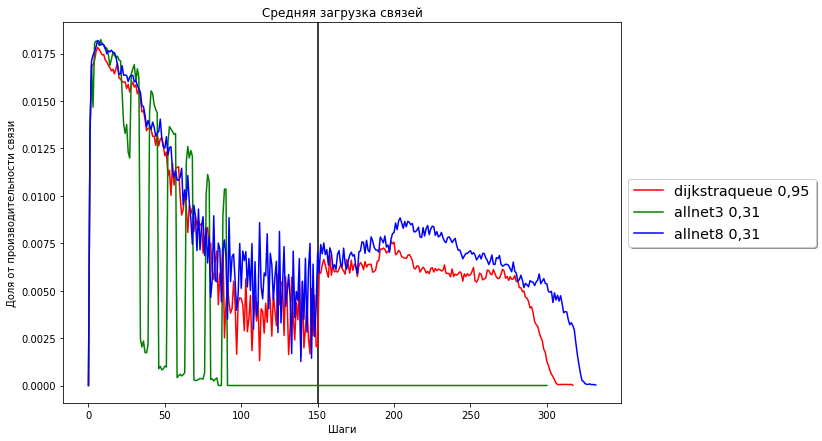

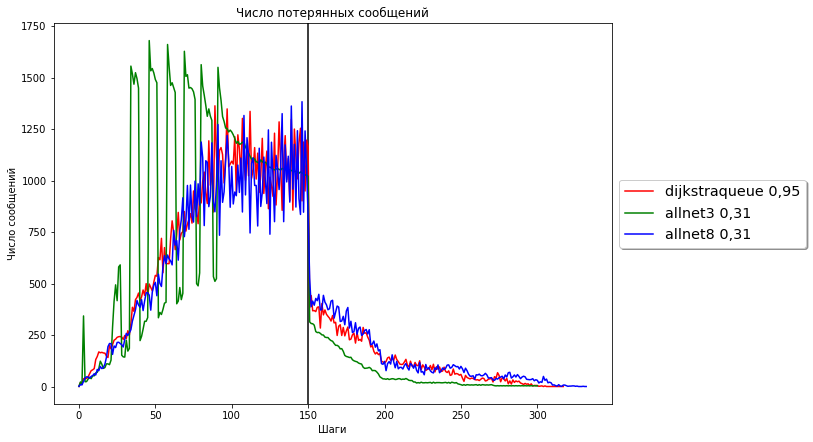

Доставлено 19476 Потеряно 87.0161% -dijkstraqueue 0,95
Доставлено 7757 Потеряно 94.8287% -allnet3 0,31
Доставлено 22161 Потеряно 85.2261% -allnet8 0,31


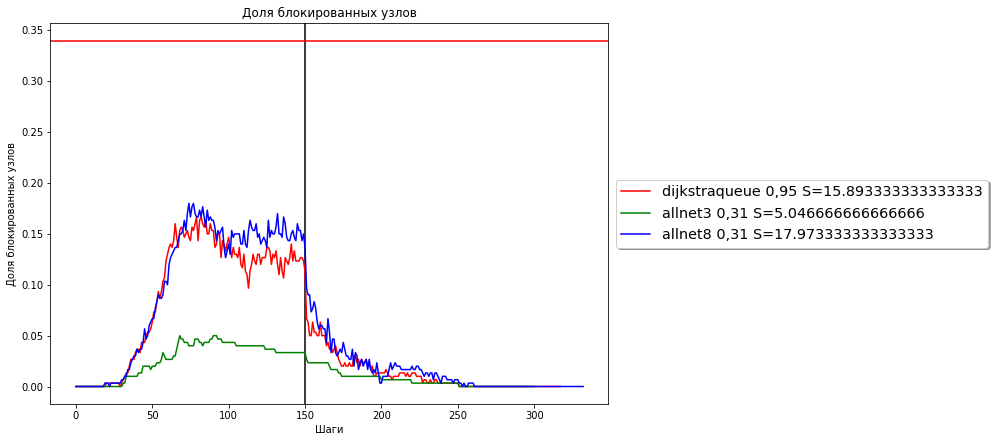

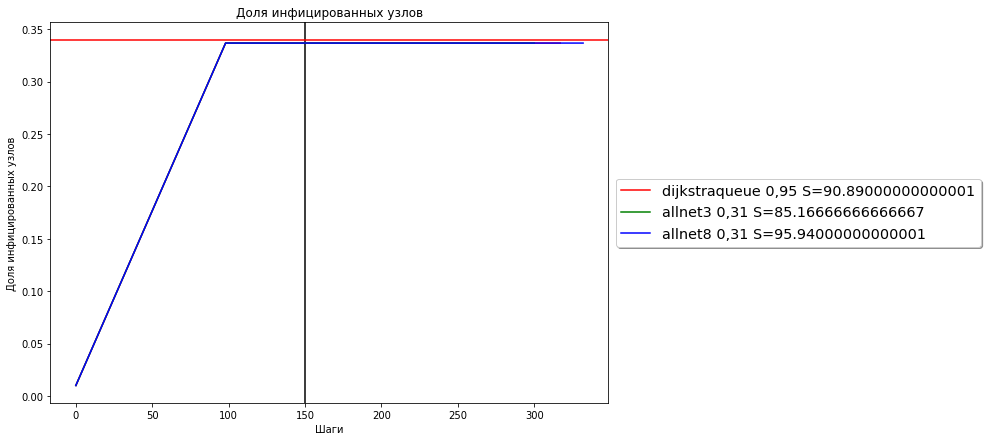

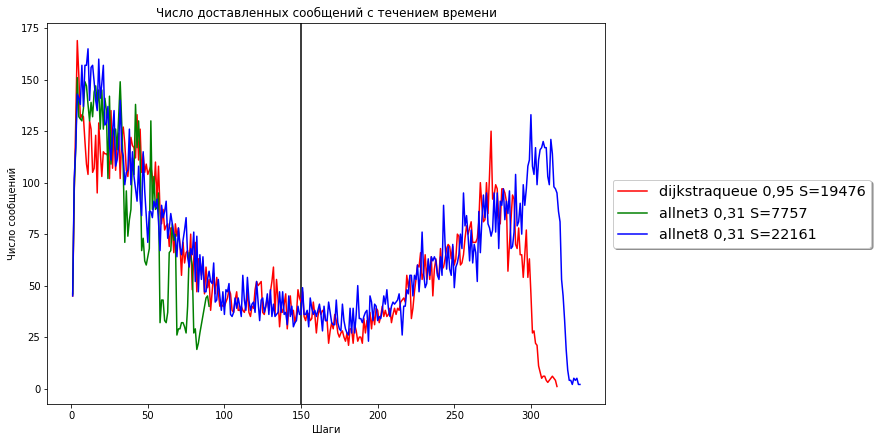

In [4]:
quantity = 1000;
log_tags = [
{"tag":  "8955ec2e-8a18-42aa-8b2c-81d3e4259526", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "973f8b3c-ac7a-400a-a99a-93718d6c34b0", "label": "allnet3 0,31", "color": "green"},
{"tag":  "ab425058-47c0-442c-8937-a271615c2b68", "label": "allnet8 0,31", "color": "blue"},
]
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

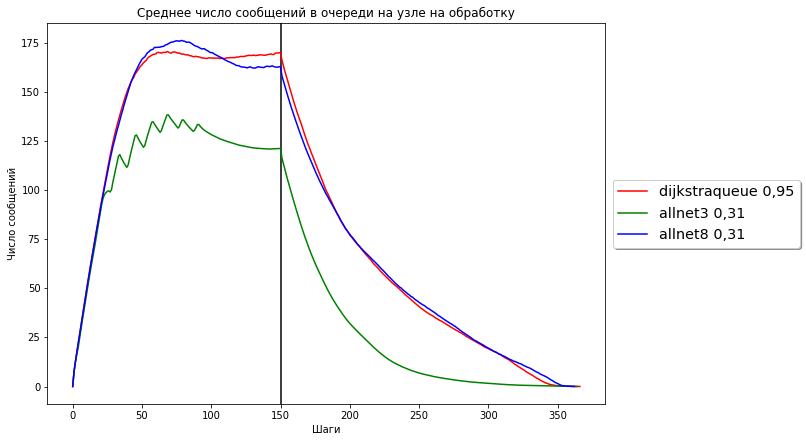

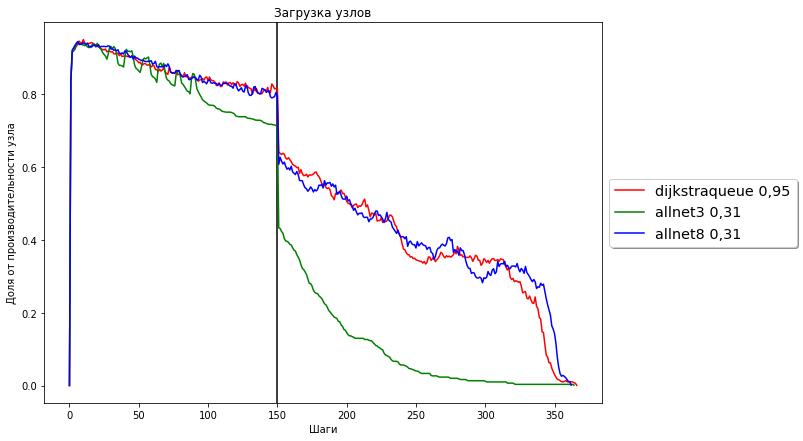

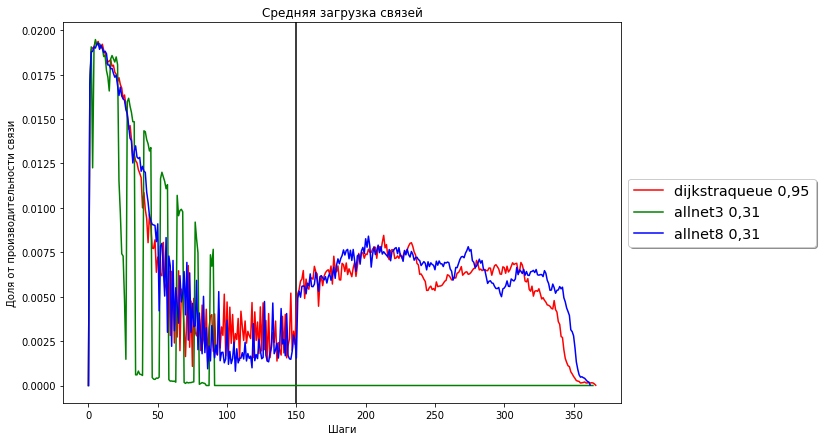

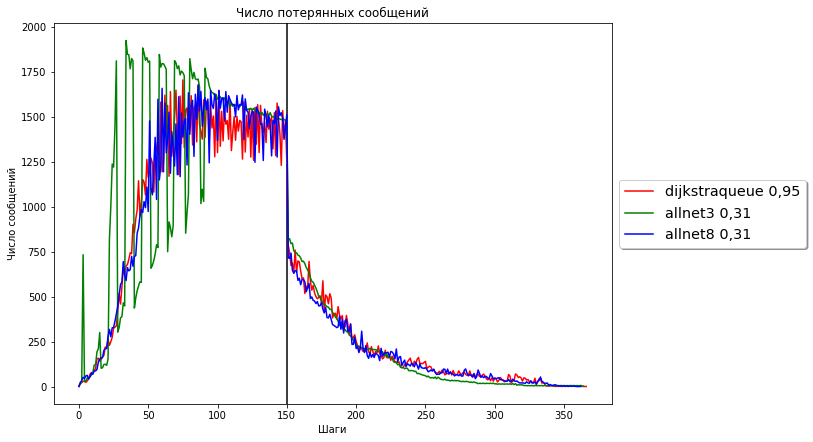

Доставлено 20226 Потеряно 91.0107% -dijkstraqueue 0,95
Доставлено 5134 Потеряно 97.7182% -allnet3 0,31
Доставлено 20752 Потеряно 90.7769% -allnet8 0,31


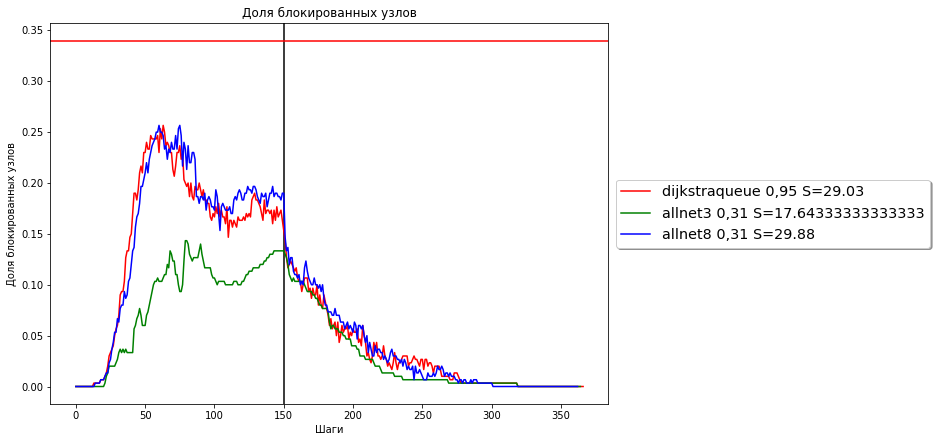

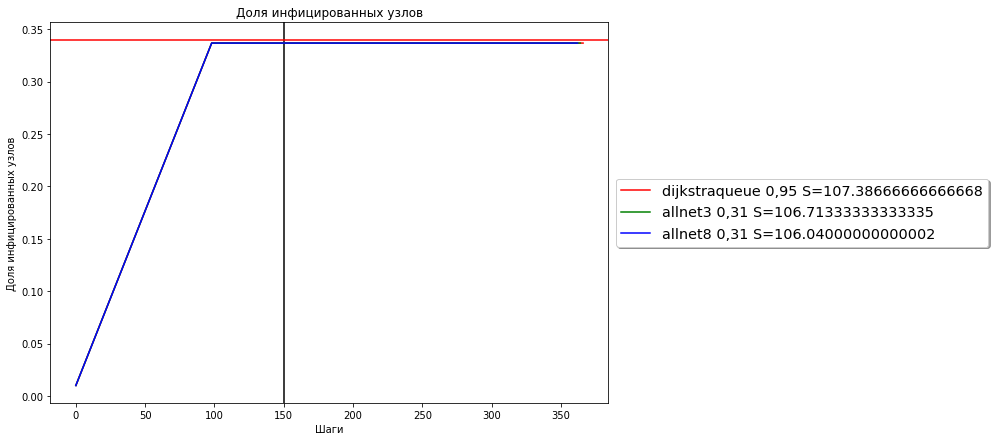

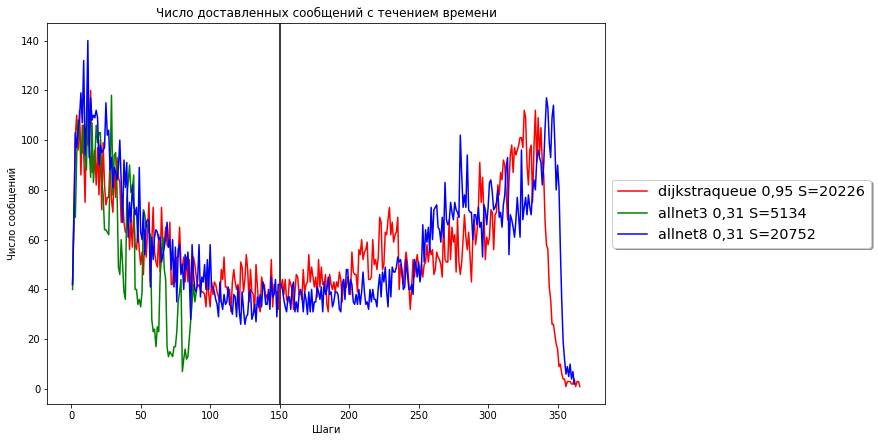

In [5]:
quantity = 1500;
log_tags = [
{"tag":  "6b1378c1-d593-408b-8e25-afdcb912fb79", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "98c6caaf-1a7d-481c-8c8e-00b9b381bf5c", "label": "allnet3 0,31", "color": "green"},
{"tag":  "3e905acf-00af-459b-9389-cfcf78405bc8", "label": "allnet8 0,31", "color": "blue"},
]
showStat()
showStatBlocked();  
showStatMessage();

Доставлено 22351 Потеряно 50.3322% -dijkstraqueue 0,95
Доставлено 14203 Потеряно 68.4385% -allnet3 0,31
Доставлено 23949 Потеряно 46.7812% -allnet8 0,31


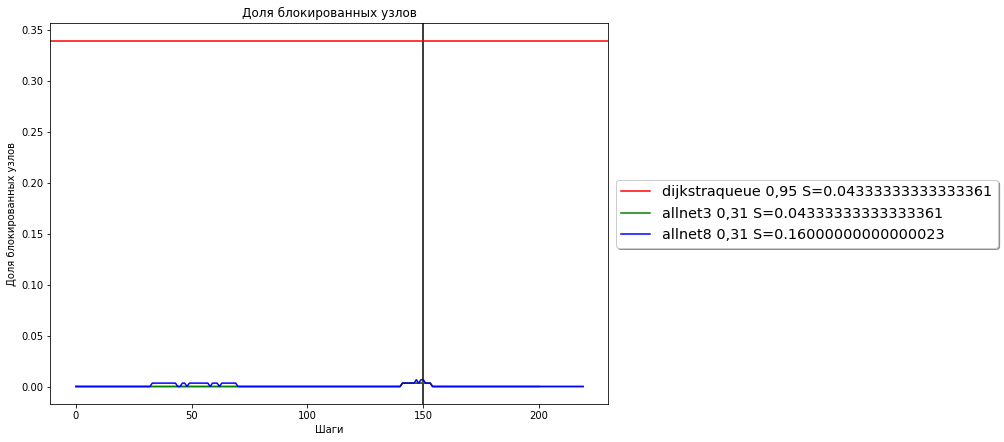

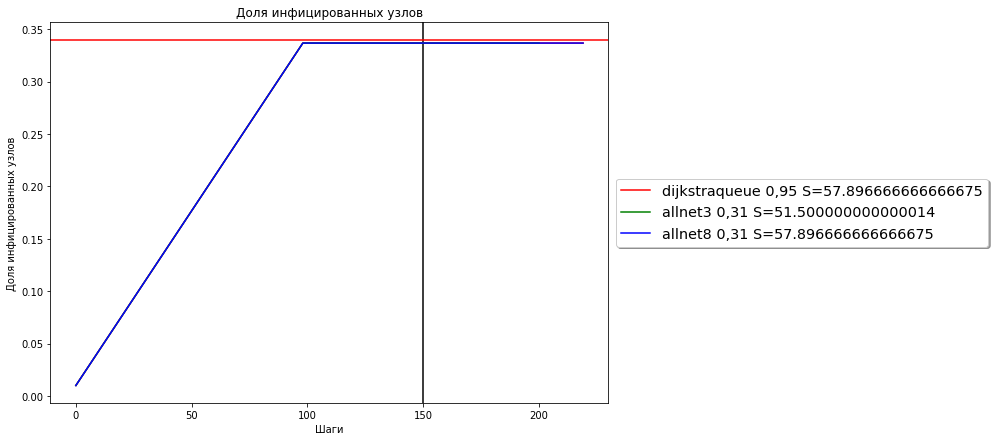

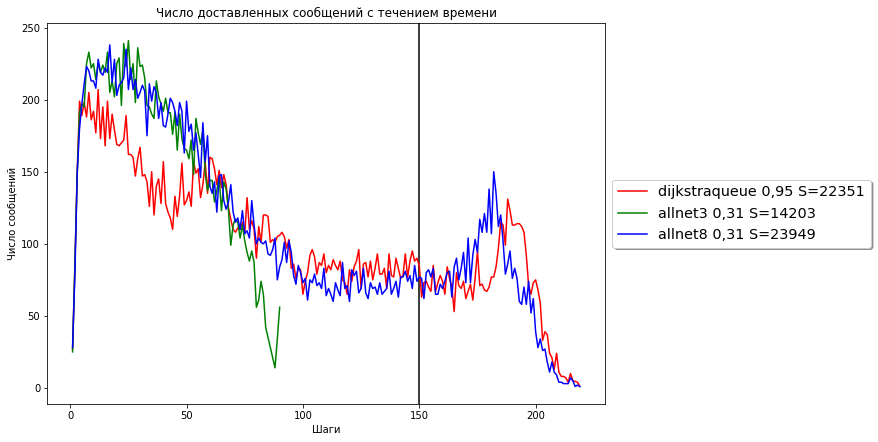

Доставлено 24132 Потеряно 77.0174% -dijkstraqueue 0,95
Доставлено 10434 Потеряно 90.0630% -allnet3 0,31
Доставлено 24848 Потеряно 76.3355% -allnet8 0,31


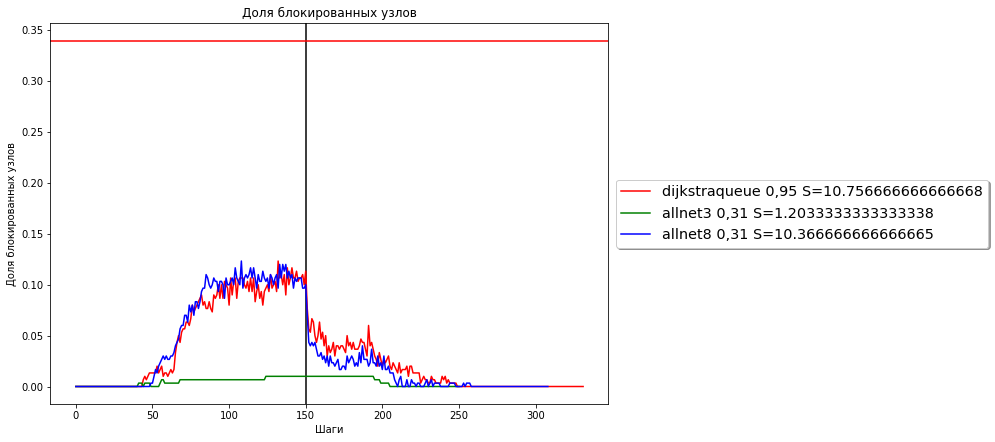

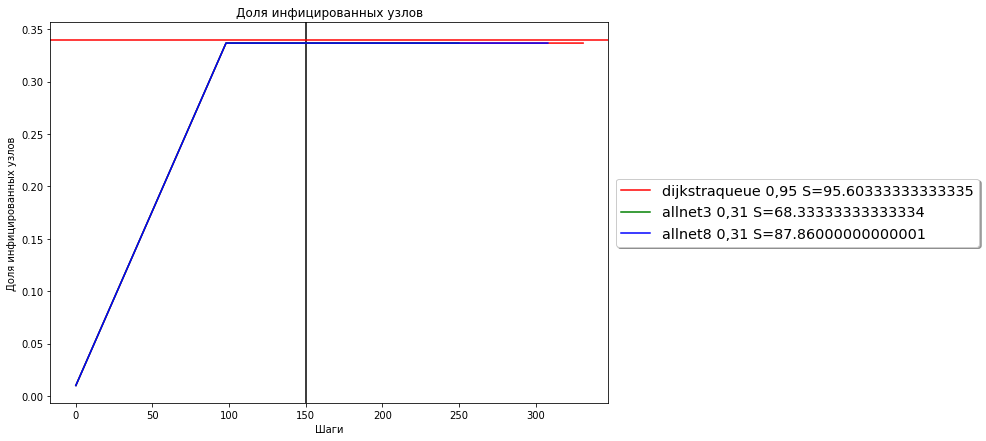

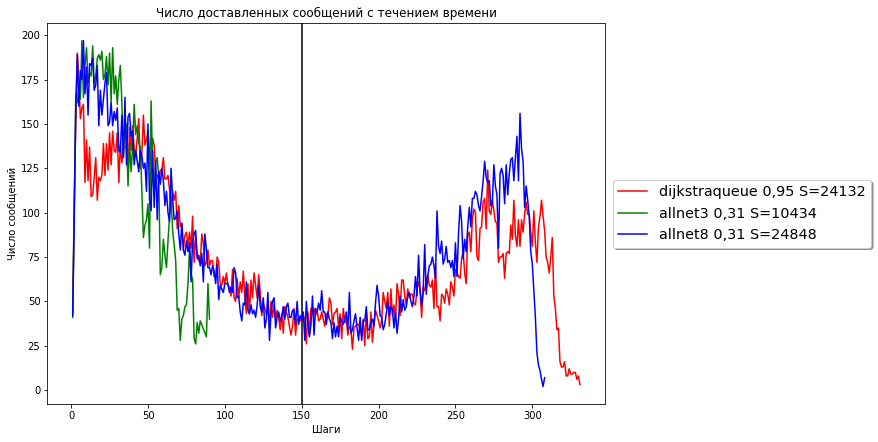

Доставлено 23163 Потеряно 82.8423% -dijkstraqueue 0,95
Доставлено 8275 Потеряно 93.8704% -allnet3 0,31
Доставлено 23696 Потеряно 82.4475% -allnet8 0,31


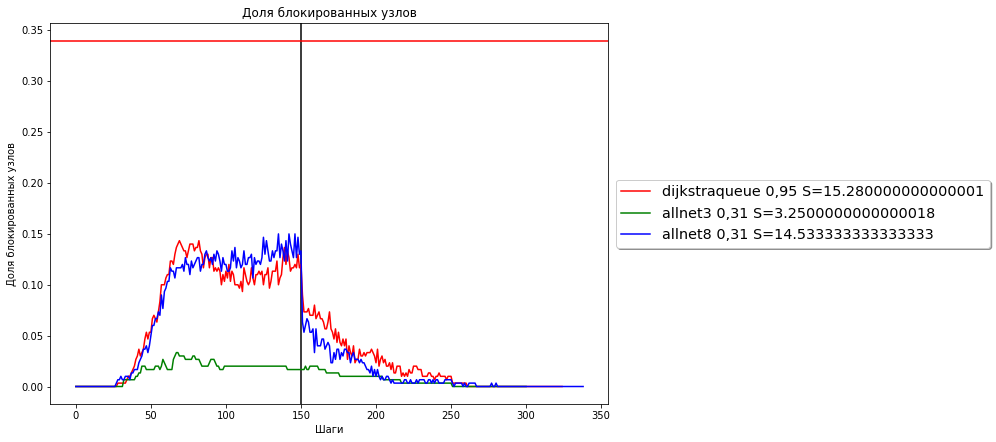

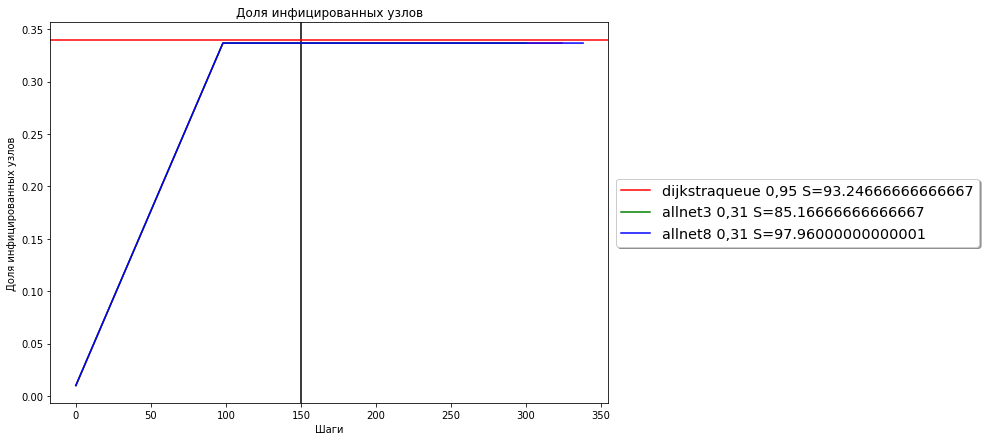

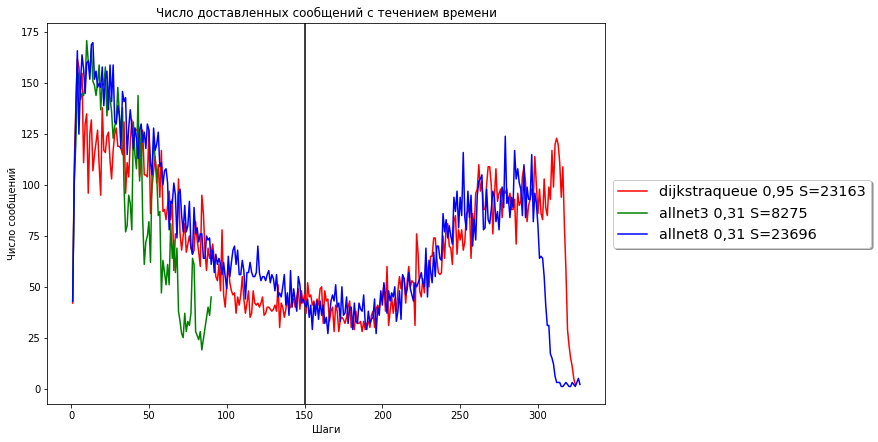

Доставлено 20916 Потеряно 89.2739% -dijkstraqueue 0,95
Доставлено 6114 Потеряно 96.8646% -allnet3 0,31
Доставлено 22054 Потеряно 88.6903% -allnet8 0,31


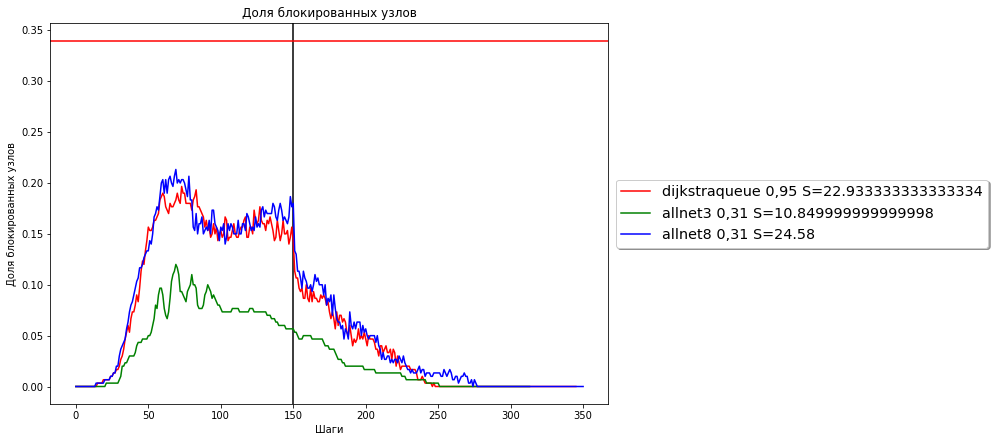

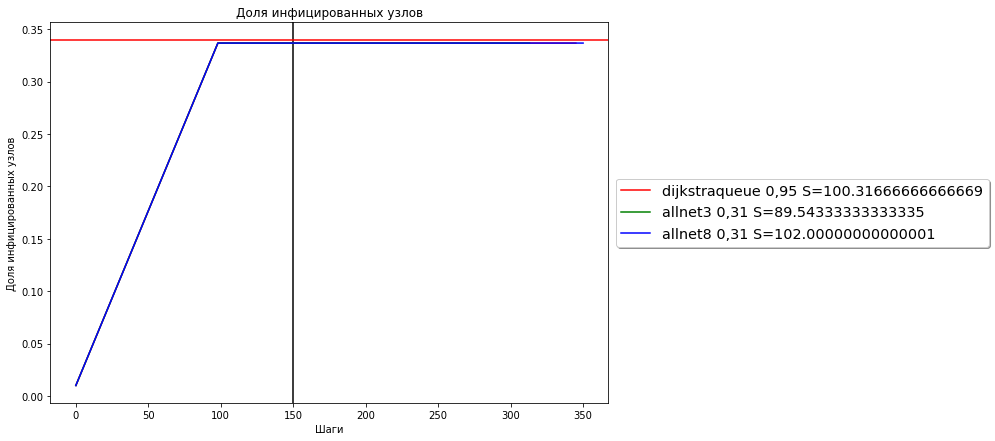

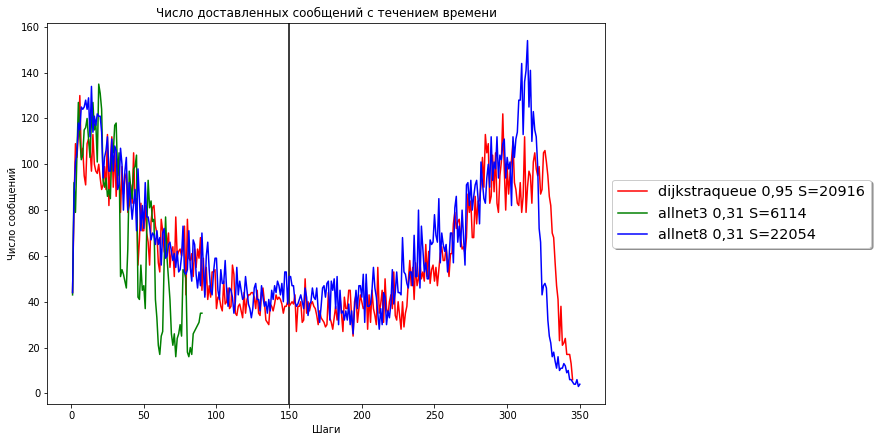

In [6]:
quantity = 300;
log_tags = [
{"tag":  "3847dccb-a753-4c24-b3b6-91da94724d20", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "b8538e50-469e-4be6-b799-072441e2cdd5", "label": "allnet3 0,31", "color": "green"},
{"tag":  "5dde04f4-eb44-4607-abb4-ab3dee58201f", "label": "allnet8 0,31", "color": "blue"},
]
showStatBlocked();
showStatMessage();

quantity = 700;
log_tags = [
{"tag":  "369b6766-6b5e-43a3-9b0c-d2e6d8fea804", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "8260e0be-4b21-4639-af49-4fd1dc97045e", "label": "allnet3 0,31", "color": "green"},
{"tag":  "ef702084-d425-47ad-b821-d922e773c961", "label": "allnet8 0,31", "color": "blue"},
]
showStatBlocked();
showStatMessage();

quantity = 900;
log_tags = [
{"tag":  "bc317276-f00b-4239-b52e-0a73b7f9fe3c", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "ebf59543-f366-47ad-bb67-779a24342cf7", "label": "allnet3 0,31", "color": "green"},
{"tag":  "bdf94cae-a6fd-4b7e-98b9-41d6f3536642", "label": "allnet8 0,31", "color": "blue"},
]
showStatBlocked();
showStatMessage();

quantity = 1300;
log_tags = [
{"tag":  "d94f736b-dcbb-420c-bfaf-ed6bb477c90b", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "e4a090bc-28db-4b83-b133-a8cb9f29f4ae", "label": "allnet3 0,31", "color": "green"},
{"tag":  "c8573367-9b52-4b9a-8af4-50dde2549e57", "label": "allnet8 0,31", "color": "blue"},
]
showStatBlocked();
showStatMessage();

      dijkstraqueue 0,95  allnet3 0,31  allnet8 0,31
100             3.929271      1.942204      2.729751
300            19.667896      5.002578     16.077598
500            42.172451      9.213357     42.944094
700            47.784297     11.766364     48.196084
900            44.492345     16.580514     42.067096
1000           39.426470     17.846434     45.547476
1300           42.597269     23.939262     42.835642
1500           42.894432     28.429420     42.909983


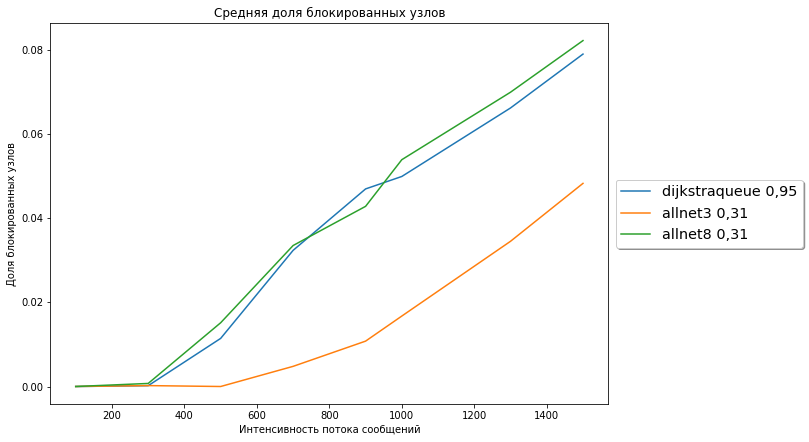

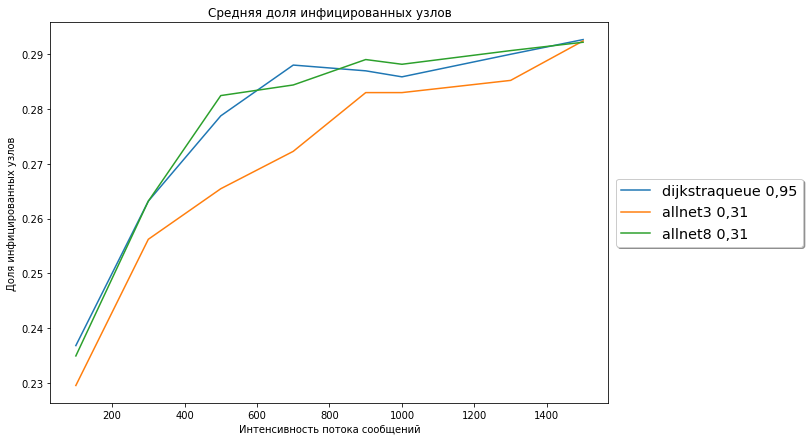

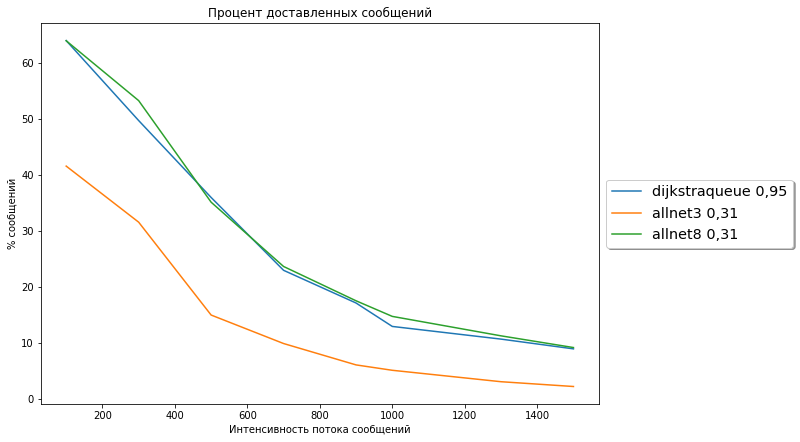

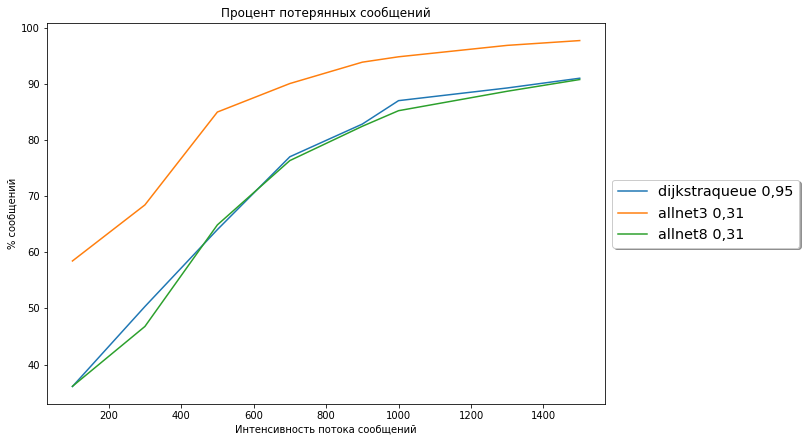

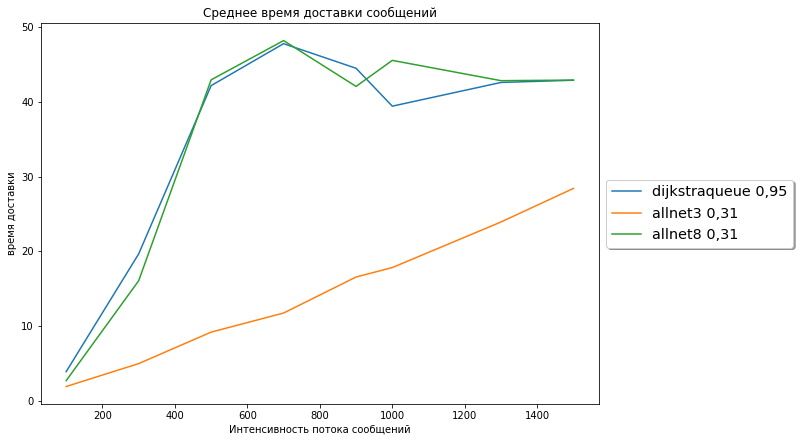

In [7]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

summInfected.sort_index(inplace=True)
axs = summInfected.plot()
axs.set_title("Средняя доля инфицированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля инфицированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()
print (MessageTimeSpent)

In [8]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())
print("")
print(summInfected.mean().to_string())

dijkstraqueue 0,95    0.035802
allnet3 0,31          0.014433
allnet8 0,31          0.037329

dijkstraqueue 0,95    72.201837
allnet3 0,31          85.652298
allnet8 0,31          71.406782

dijkstraqueue 0,95    35.370554
allnet3 0,31          14.340017
allnet8 0,31          35.413466

dijkstraqueue 0,95    0.277745
allnet3 0,31          0.270863
allnet8 0,31          0.278084
